# Notebook 2 : Modèle CNN Personnel
## Projet Le Refuge - Classification de races de chiens

Dans ce notebook, on va :
1. Récupérer les données prétraitées
2. Créer notre propre modèle CNN
3. L'entraîner et visualiser les résultats
4. Tester quelques variations d'hyperparamètres

## 1. Import des bibliothèques et récupération des données


In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time
import os
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from glob import glob

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping
import pickle

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [118]:
# CHARGEMENT DES DONNÉES DU NOTEBOOK 1
with open('donnees_preparees.pkl', 'rb') as f:
    donnees = pickle.load(f)

data = donnees['data']
data_test = donnees['data_test']
le = donnees['le']
num_classes = donnees['num_classes']

print(f"✅ Données chargées depuis le notebook 1")
print(f"Classes : {list(le.classes_)}")
print(f"Train : {len(data)} images | Test : {len(data_test)} images")


# PARAMÈTRES ET DATA AUGMENTATION

IMG_SIZE = 128  # Taille réduite pour le CNN maison
BATCH_SIZE = 32

data_augmentation = tf.keras.Sequential([
    layers.InputLayer(input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])


# PRÉPARATION DES IMAGES

def prepare_images(df, augmentation=False):
    def load_and_preprocess(path, label):
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
        img = img / 255.0
        return img, label
    
    def apply_augmentation(img, label):
        img = tf.expand_dims(img, axis=0)
        img = data_augmentation(img, training=True)
        img = tf.squeeze(img, axis=0)
        return img, label
    
    ds = tf.data.Dataset.from_tensor_slices((df['image_path'].values, df['label'].values))
    ds = ds.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    if augmentation:
        ds = ds.map(apply_augmentation, num_parallel_calls=tf.data.AUTOTUNE)
    return ds.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

train_ds = prepare_images(data, augmentation=True)
test_ds = prepare_images(data_test, augmentation=False)

print(f"\n{'='*40}")
print(f"Données prêtes ! {num_classes} classes")
print(f"IMG_SIZE = {IMG_SIZE} (réduit pour CNN maison)")
print(f"{'='*40}")

✅ Données chargées depuis le notebook 1
Classes : ['Autre', 'Chihuahua', 'Eskimo_dog', 'golden_retriever']
Train : 479 images | Test : 120 images


c:\Users\lza\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Données prêtes ! 4 classes
IMG_SIZE = 128 (réduit pour CNN maison)


## 2. Création du modèle CNN "maison"

On crée un CNN simple avec :
- 3 blocs de convolution + MaxPooling
- Une couche Flatten pour "aplatir" les features
- Des couches Dense pour la classification

In [119]:
# Création du modèle maison (simple CNN)
model_simple = Sequential([
    # On définit la forme de l'entrée
    layers.InputLayer(input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    
    # Data augmentation intégrée
    data_augmentation,
    
    # Bloc 1 : Convolution + Pooling  - Détecte les bords, contours
    layers.Conv2D(13, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    
    # Bloc 2 - Détecte les textures, formes simples
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    
    # Bloc 3 - Détecte les parties (oreilles, museaux, yeux)
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    
    # Classification - Combine le tout pour classifier
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax') #activation pour avoir des probabilités
])

# Compilation du modèle
model_simple.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_simple.summary()

#Vue d'ensemble du processus : Image (224×224×3) trop lourde, on va réduire à 128x128x3→ Conv → Pool → Conv → Pool → Conv → Pool → Flatten → Dense → Output

Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_30 (Sequential)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_63 (Conv2D)              │ (None, 128, 128, 13)   │           364 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_63 (MaxPooling2D) │ (None, 64, 64, 13)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_64 (Conv2D)              │ (None, 64, 64, 32)     │         3,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_64 (MaxPooling2D) │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_65 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_65 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_18 (Flatten)            │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,120,432 (8.09 MB)

 Trainable params: 2,120,432 (8.09 MB)

 Non-trainable params: 0 (0.00 B)

## 3. Entraînement du modèle

In [120]:
# Callback pour arrêter si le modèle ne progresse plus
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entraînement
start = time.time()
history_simple = model_simple.fit(
    train_ds,
    validation_data=test_ds,
    epochs=10,
    callbacks=[early_stop]
)
temps_simple = time.time() - start
print(f"Temps d'entraînement modèle simple : {temps_simple:.1f} secondes")

Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 0.2672 - loss: 1.4274 - val_accuracy: 0.2500 - val_loss: 1.3788
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.2881 - loss: 1.3570 - val_accuracy: 0.3833 - val_loss: 1.3413
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.3904 - loss: 1.2942 - val_accuracy: 0.3917 - val_loss: 1.2456
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 0.4259 - loss: 1.2431 - val_accuracy: 0.4750 - val_loss: 1.1859
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 0.4196 - loss: 1.2067 - val_accuracy: 0.4917 - val_loss: 1.1617
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.4405 - loss: 1.2129 - val_accuracy: 0.5250 - val_loss: 1.1234
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.4196 - loss: 1.1974 - val_accuracy: 0.4750 - val_loss: 1.1307
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.4614 - loss: 1.1666 - val_accuracy: 0.

## 4. Visualisation de l'apprentissage

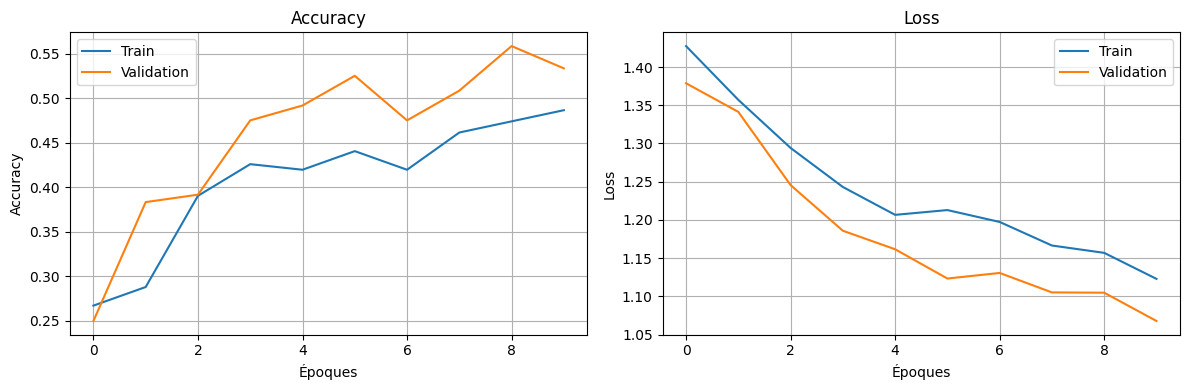

In [121]:
# Courbes d'apprentissage
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_simple.history['accuracy'], label='Train')
plt.plot(history_simple.history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.xlabel('Époques')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_simple.history['loss'], label='Train')
plt.plot(history_simple.history['val_loss'], label='Validation')
plt.title('Loss')
plt.xlabel('Époques')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## 5. Optimisation des hyperparamètres

On teste quelques variations pour améliorer le modèle :
- Ajout de **Dropout** pour éviter le surapprentissage
- Modification du nombre de **filtres**

In [ ]:
# Modèle amélioré avec Dropout - 3 correspond aux 3 canaux de couleurs
model_v2 = Sequential([
    layers.InputLayer(input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    data_augmentation,
    
    # Bloc 1
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),  # Ajout Dropout
    
    # Bloc 2
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    
    # Bloc 3
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    
    # Classification
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.25), 
    #layers.Dropout(0.25),  #retenter avec un 0.25, 0.5 semble trop aggressif 
    layers.Dense(num_classes, activation='softmax')
])

model_v2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print("Modèle V2 créé (avec Dropout)")

Modèle V2 créé (avec Dropout)


In [123]:
# Entraînement du modèle V2 avec mesure du temps
start = time.time()
history_v2 = model_v2.fit(
    train_ds,
    validation_data=test_ds,
    epochs=10,
    callbacks=[early_stop]
)
temps_v2 = time.time() - start
print(f" Temps d'entraînement modèle V2 : {temps_v2:.1f} secondes")

Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 285ms/step - accuracy: 0.2568 - loss: 1.6722 - val_accuracy: 0.3333 - val_loss: 1.3842
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 263ms/step - accuracy: 0.3027 - loss: 1.3655 - val_accuracy: 0.2833 - val_loss: 1.3868
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 278ms/step - accuracy: 0.3695 - loss: 1.3191 - val_accuracy: 0.4167 - val_loss: 1.2897
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 278ms/step - accuracy: 0.3883 - loss: 1.2987 - val_accuracy: 0.4417 - val_loss: 1.2960
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 281ms/step - accuracy: 0.4259 - loss: 1.2694 - val_accuracy: 0.4667 - val_loss: 1.2337
 Temps d'entraînement modèle V2 : 23.5 secondes


## 6. Comparaison des modèles

In [128]:
# Évaluation des deux modèles
score_simple = model_simple.evaluate(test_ds, verbose=0)
score_v2 = model_v2.evaluate(test_ds, verbose=0)
accuracy_v2 = score_v2[1] * 100 


print("RÉSULTATS")
print(f"Modèle simple   : {score_simple[1]*100:.2f}%")
print(f"Modèle + Dropout: {score_v2[1]*100:.2f}%")

#Le Dropout (neurones désactivés aléatoirement) est sans bénéfice ici

RÉSULTATS
Modèle simple   : 53.33%
Modèle + Dropout: 33.33%


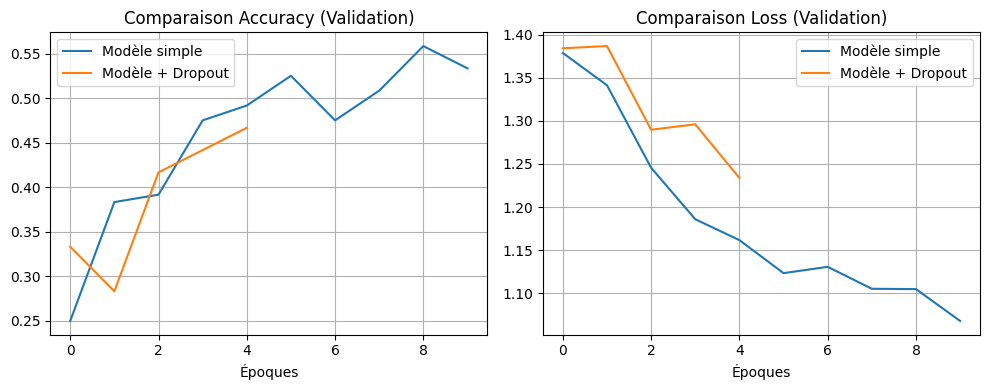

In [125]:
# Comparaison visuelle
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history_simple.history['val_accuracy'], label='Modèle simple')
plt.plot(history_v2.history['val_accuracy'], label='Modèle + Dropout')
plt.title('Comparaison Accuracy (Validation)')
plt.xlabel('Époques')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_simple.history['val_loss'], label='Modèle simple')
plt.plot(history_v2.history['val_loss'], label='Modèle + Dropout')
plt.title('Comparaison Loss (Validation)')
plt.xlabel('Époques')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## 7. Sauvegarde du meilleur modèle

In [126]:
# Sauvegarder les résultats des modèles maison
resultats_maison = {
    'score_simple': score_simple[1] * 100,
    'score_v2': score_v2[1] * 100,
    'temps_simple': temps_simple,
    'temps_v2': temps_v2
}

with open('resultats_maison.pkl', 'wb') as f:
    pickle.dump(resultats_maison, f)

print("Résultats sauvegardés dans resultats_maison.pkl")

Résultats sauvegardés dans resultats_maison.pkl


In [127]:
# On garde le meilleur modèle
if score_v2[1] > score_simple[1]:
    best_model = model_v2
    print("Meilleur modèle : V2 (avec Dropout)")
else:
    best_model = model_simple
    print("Meilleur modèle : Simple")

# Sauvegarde
best_model.save('model_cnn_maison.keras')
print("Modèle sauvegardé")

Meilleur modèle : Simple
Modèle sauvegardé


## Conclusion

On a créé un CNN "maison" et testé l'impact du Dropout sur les performances.

Un CNN entraîné from scratch nécessite beaucoup de données (des milliers d'images par classe).  
Avec seulement 130 images par classe, le modèle n'a pas assez d'exemples pour apprendre les caractéristiques distinctives de chaque race.  
Le Dropout n'améliore pas les performances car le problème principal n'est pas l'overfitting mais le manque de données.  
Le modèle est en underfitting : il n'a pas assez d'exemples pour apprendre.  
C'est pourquoi le Transfer Learning, qui utilise des connaissances pré-apprises sur des millions d'images, est la solution adaptée.  